In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [22]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
macro_data = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(macro_data.shape)  # (123, 8)
macro_data.head()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


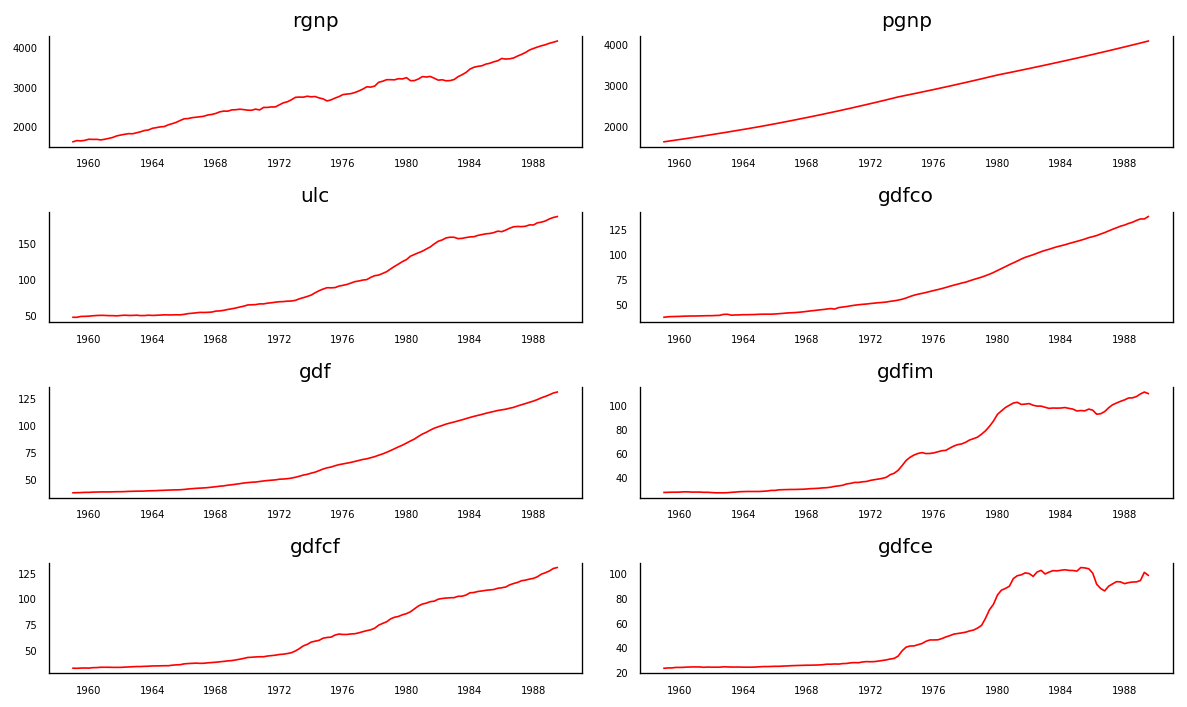

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [26]:
ad_fuller_result_1 = adfuller(macro_data['gdfim'].diff()[1:])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller((macro_data['gdfce'].diff()[1:]).diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realgdp
ADF Statistic: -4.2444214126642485
p-value: 0.000553653708669568

---------------------

realcons
ADF Statistic: -4.375379730160643
p-value: 0.000328071866991873


In [27]:
print('gdfce causes ulc?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['gdfim', 'gdfce']], 4)

print('\nulc causes rgnp?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['gdfce', 'gdfim']], 4)

gdfce causes ulc?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=60.2942 , p=0.0000  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=61.8142 , p=0.0000  , df=1
likelihood ratio test: chi2=50.0084 , p=0.0000  , df=1
parameter F test:         F=60.2942 , p=0.0000  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2509  , p=0.0066  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=10.9544 , p=0.0042  , df=2
likelihood ratio test: chi2=10.4866 , p=0.0053  , df=2
parameter F test:         F=5.2509  , p=0.0066  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7587  , p=0.0129  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=11.9746 , p=0.0075  , df=3
likelihood ratio test: chi2=11.4142 , p=0.0097  , df=3
parameter F test:         F=3.7587  , p=0.0129  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based 

In [28]:
macro_data = macro_data[['gdfim','gdfce']]
print(macro_data.shape)

(123, 2)


In [29]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [30]:
print(test_df.shape)


(12, 2)


In [31]:
model = VAR(train_df.diff()[1:])

In [32]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.353       1.409       3.869       1.375
1       0.4491     0.6158*       1.567      0.5163
2       0.5029      0.7807       1.654      0.6150
3       0.5102      0.8991       1.667      0.6670
4       0.4972      0.9972       1.646      0.6988
5       0.4539       1.065       1.578      0.7003
6       0.3442       1.066       1.417      0.6354
7       0.3683       1.202       1.454      0.7043
8       0.3444       1.289       1.424      0.7252
9       0.3892       1.445       1.495      0.8148
10      0.2547       1.421       1.313      0.7251
11      0.3010       1.579       1.383      0.8163
12      0.3040       1.693       1.397      0.8640
13      0.1957       1.696       1.263      0.8006
14     -0.1839       1.427      0.8726      0.4657
15     -0.3140       1.408      0.7747      0.3805
16     -0.4437       1.390     

In [43]:
var_model = VARMAX(train_df, order=(1,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:     ['gdfim', 'gdfce']   No. Observations:                  111
Model:                         VAR(1)   Log Likelihood                -345.810
                          + intercept   AIC                            709.619
Date:                Mon, 24 Jan 2022   BIC                            734.005
Time:                        17:50:46   HQIC                           719.512
Sample:                    01-01-1959                                         
                         - 07-01-1986                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):           36.52, 19.48   Jarque-Bera (JB):        78.08, 103.41
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):       27.02, 48.84   Skew:                      0.74, -0.49
Prob(H) (two-sided):            0.00,

In [44]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [51]:
predictions.columns=['Pred_gdfim','Pred_gdfce']
predictions

,Pred_gdfim,Pred_gdfce
1986-10-01,93.636536,88.732502
1987-01-01,94.329387,89.817093
1987-04-01,94.978803,90.853760
1987-07-01,95.585070,91.842536
1987-10-01,96.148505,92.783492
1988-01-01,96.669458,93.676744
1988-04-01,97.148307,94.522444
1988-07-01,97.585463,95.320786
1988-10-01,97.981365,96.072001
1989-01-01,98.336477,96.776355


In [52]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)
test_vs_pred

,gdfim,gdfce,Pred_gdfim,Pred_gdfce
1986-10-01,94.7,85.6,93.636536,88.732502
1987-01-01,97.9,89.4,94.329387,89.817093
1987-04-01,100.4,91.3,94.978803,90.853760
1987-07-01,101.9,93.1,95.585070,91.842536
1987-10-01,103.3,92.9,96.148505,92.783492
1988-01-01,104.5,91.5,96.669458,93.676744
1988-04-01,106.1,92.3,97.148307,94.522444
1988-07-01,106.2,92.8,97.585463,95.320786
1988-10-01,107.3,92.9,97.981365,96.072001
1989-01-01,109.5,94.0,98.336477,96.776355


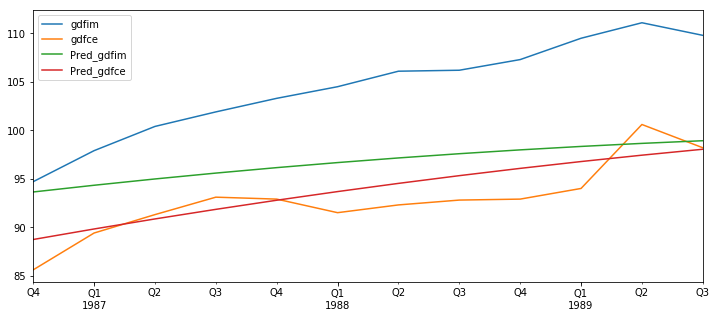

In [53]:
test_vs_pred.plot(figsize=(12,5))

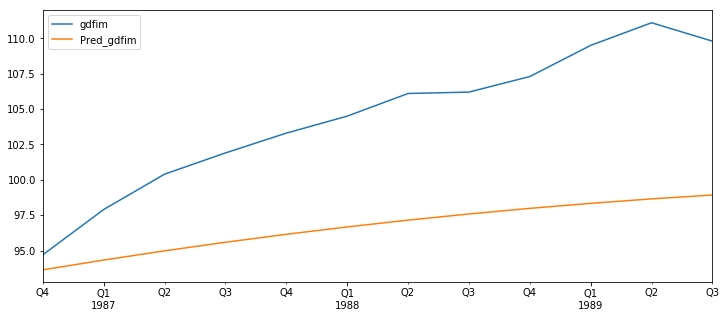

In [55]:
test_vs_pred[['gdfim','Pred_gdfim']].plot(figsize=(12,5))

In [ ]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_ulc=math.sqrt(mean_squared_error(predictions['ulc_predicted'],test_df['ulc']))
print('Mean value of ULC is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['ulc']),rmse_ulc))

rmse_rgnp=math.sqrt(mean_squared_error(predictions['rgnp_predicted'],test_df['rgnp']))
print('Mean value of RGNP is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['rgnp']),rmse_rgnp))

In [ ]:
40.434928819033/178.56666666666666

In [ ]:
327.8523683404757/3970.6916666666666